In [1]:
import pandas as pd
import numpy  as np 
import numpy.matlib as npm

import matplotlib.pyplot as plt
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting seed

SEED = 101
np.random.seed(SEED)

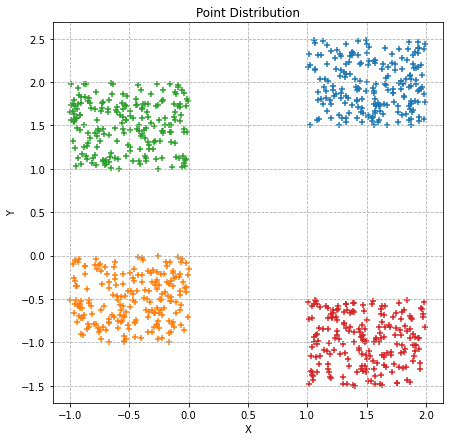

In [4]:
# Toy Dataset creation

## Creating a toy dataset

rand_values = np.random.rand(1000)

cluster_1 = np.array(list(zip( 1  + np.random.rand(200), 1.5 + np.random.rand(200))))
cluster_2 = np.array(list(zip( -1 + np.random.rand(200),  -1 + np.random.rand(200))))
cluster_3 = np.array(list(zip( -1 + np.random.rand(200),   1 + np.random.rand(200))))
cluster_4 = np.array(list(zip(  1 + np.random.rand(200),-1.5 + np.random.rand(200))))

clusters = [cluster_1, cluster_2, cluster_3, cluster_4]

## Plotting the toy dataset

fig = plt.figure(figsize=(7, 7))
for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1], marker='+')
plt.grid(ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Distribution');

## Creating the toy dataframe

toy_df = pd.DataFrame()
for cluster_id, cluster in enumerate(clusters):
    sub_df = pd.DataFrame(cluster, columns=['x', 'y'])
    sub_df['cluster_id'] = cluster_id + 1
    toy_df = pd.concat([toy_df, sub_df])

In [5]:
# Getting the dataset for unsupervised modelling

np.random.seed(101)
toy_df_unsupervised = toy_df[['x', 'y']].sample(frac=1).reset_index(drop=True)
toy_df_unsupervised = toy_df_unsupervised.values

In [6]:
# K-Means Clustering Algorithm

## Calculate euclidean distance
def euclidean_distance(p1, p2):
    distance = np.sqrt(np.sum((p1-p2)**2))
    return distance

## Assign cluster ids based on closest centroid
def assign_cluster_ids(centroids, points):
    cluster_ids = []
    for i in range(points.shape[0]):
        distances = [euclidean_distance(centroid, points[i]) for centroid in centroids]
        minm_distance = min(distances)
        cluster_id = [x for x, distance in enumerate(distances) if distance == minm_distance]
        cluster_ids.append(cluster_id[0])
    return cluster_ids

## Calculate new centroids
def generate_new_centroids(cluster_ids, points):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(points), pd.DataFrame(cluster_ids, columns=['cluster'])], axis=1)
    for cluster_id in set(cluster_df['cluster']):
        current_cluster_points = cluster_df[cluster_df['cluster']==cluster_id][cluster_df.columns[:-1]] 
        cluster_points_centroid = current_cluster_points.mean(axis=0).values
        new_centroids.append(cluster_points_centroid)
    return np.array(new_centroids)

## Calculate variance
def calculate_variance(cluster_ids, points):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(points), pd.DataFrame(cluster_ids, columns=['cluster'])], axis=1)
    for cluster_id in set(cluster_df['cluster']):
        current_cluster_points = cluster_df[cluster_df['cluster']==cluster_id][cluster_df.columns[:-1]] 
        cluster_points_centroid = current_cluster_points.mean(axis=0).values
        mean_repmat = npm.repmat(cluster_points_centroid, current_cluster_points.shape[0], 1)
        sum_squares.append(np.sum(np.sum((current_cluster_points - mean_repmat)**2)))
    return np.mean(sum_squares)

## Perform KMeans clustering
def kmeans(X, k=3, n_iterations=50):
    centroids = np.array([X[i] + np.random.rand() for i in range(k)])
    variance_list = []

    for i in range(n_iterations):
        cluster_ids = assign_cluster_ids(centroids, X)
        centroids = generate_new_centroids(cluster_ids, X)
        variance = calculate_variance(cluster_ids, X)
        variance_list.append([i, variance])

    return cluster_ids, centroids, variance_list

In [7]:
# Clustering using KMeans

cluster_ids, centroids, variance_list = kmeans(toy_df_unsupervised, k=5, n_iterations=5)
main_df = pd.concat([pd.DataFrame(toy_df_unsupervised), pd.DataFrame(cluster_ids, columns=['cluster_id'])], axis=1)
main_df.columns = ['x', 'y', 'cluster_id']

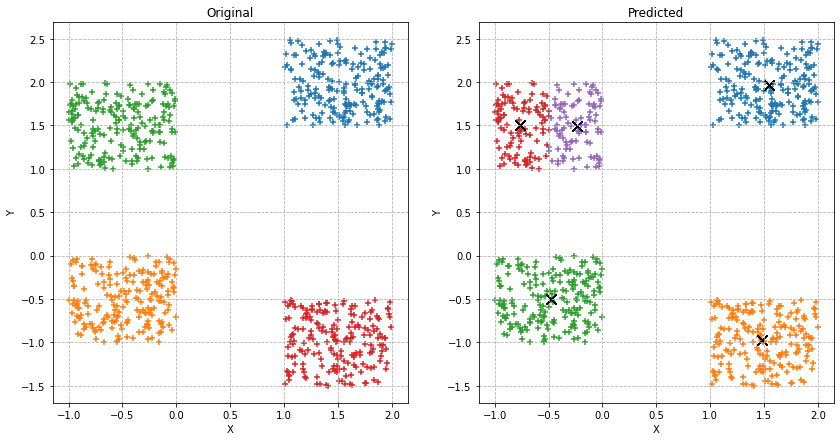

In [8]:
# Plotting Original vs Predicted for KMeans

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for _, data in toy_df.groupby('cluster_id'):
    axs[0].scatter(data['x'], data['y'], marker='+')
    axs[0].set_title("Original")
    axs[0].grid(ls='--')
    axs[0].set_ylabel('Y')
    axs[0].set_xlabel('X')

for _, data in main_df.groupby('cluster_id'):
    axs[1].scatter(data['x'], data['y'], marker='+')
    axs[1].set_title("Predicted")
    axs[1].grid(ls='--')
    axs[1].set_ylabel('Y')
    axs[1].set_xlabel('X')
    
    axs[1].scatter(centroids[:, 0], centroids[:, 1], s=100, c='k', marker='x')

Text(0.5, 1.0, 'Variance v/s k')

<Figure size 432x288 with 0 Axes>

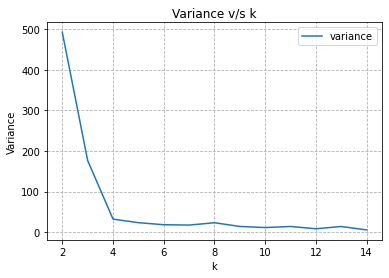

In [9]:
# Finding the elbow point

scores = []
for k in range(2, 15):
    cluster_ids, centroids, variance_list = kmeans(toy_df_unsupervised, k, n_iterations=5)
    minm_variance = np.min(np.array(variance_list)[:,1])
    scores.append((k, minm_variance))
    
analysis_df = pd.DataFrame(scores)
analysis_df.columns = ['k', 'variance']
analysis_df = analysis_df.set_index('k')

fig = plt.figure()
analysis_df.plot()
plt.grid(ls='--')
plt.ylabel('Variance');
plt.title('Variance v/s k')